In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.utils.metrics as metrics
import src.utils.gau as gaussian
import src.utils.plots as plots

from src.models import AE, RNN, LinearClassifier, get_latent_features, rnn_loss_function, ae_loss_function
from src.training import EarlyStopping, train_ae, train_rnn, train_lp, augment_data

from src.final_model import ae_loss_function, rnn_loss_function

In [2]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')

def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

In [3]:
train_template = torch.tensor(stamps_dataset['Train']['template'], dtype=torch.float32)
validation_template = torch.tensor(stamps_dataset['Validation']['template'], dtype=torch.float32)
test_template = torch.tensor(stamps_dataset['Test']['template'], dtype=torch.float32)

train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_image = torch.tensor(stamps_dataset['Train']['images'], dtype=torch.float32)
validation_image = torch.tensor(stamps_dataset['Validation']['images'], dtype=torch.float32)
test_image = torch.tensor(stamps_dataset['Test']['images'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

train_template = train_template.unsqueeze(1).repeat(1, 5, 1, 1)
validation_template = validation_template.unsqueeze(1).repeat(1, 5, 1, 1)
test_template = test_template.unsqueeze(1).repeat(1, 5, 1, 1)


train_dataset = torch.stack((train_template, train_image, train_difference), dim=3  )
validation_dataset = torch.stack((validation_template, validation_difference, validation_difference), dim=3)
test_dataset = torch.stack((test_template, test_image, test_difference), dim=3)

train_template = train_template.unsqueeze(2)  # (samples, 5, 1, 21, 21)
train_image = train_image.unsqueeze(2)        
train_difference = train_difference.unsqueeze(2)  

validation_template = validation_template.unsqueeze(2)
validation_image = validation_image.unsqueeze(2)
validation_difference = validation_difference.unsqueeze(2)

test_template = test_template.unsqueeze(2)
test_image = test_image.unsqueeze(2)
test_difference = test_difference.unsqueeze(2)

# Apilar los tensores a lo largo de la dimensión correcta
train_dataset = torch.cat((train_template, train_image, train_difference), dim=2)
validation_dataset = torch.cat((validation_template, validation_image, validation_difference), dim=2)
test_dataset = torch.cat((test_template, test_image, test_difference), dim=2)

# Crear los conjuntos de datos
train_dataset = TensorDataset(train_dataset, train_class_0)
validation_dataset = TensorDataset(validation_dataset, validation_class_0)
test_dataset = TensorDataset(test_dataset, test_class_0)

In [20]:
#rnn parameters
rnn_type = 'RNN'
hidden_dim = 128
num_layers = 1

# autoencoder params
latent_dim = 128
n_channels = 3
n_classes = 3

# training params
ae_loss = ae_loss_function
rnn_loss = rnn_loss_function

max_epochs = 300
max_time = 1000 #minutos
lr = 10e-5
batch_size = 256
dropout_prob = 0.15

random_sampler = True
use_gpu = True
augmentation = True
only_classifier = False
early_stop = 50
num_cpu = 0

In [21]:
import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)


# modelo_final = fm.FinalModel(128, 3, 'LSTM', 128, 1, 0,  3, name='4th_iteration')
# modelo_final.load_state_dict(torch.load(f'models/2_2.pth'))

modelo_final = fm.FinalModel(latent_dim, n_channels, rnn_type, hidden_dim, num_layers, dropout_prob,  n_classes, name='RNN model with augmentation')

early_stop = 30
batch_size = 64

stage = 'ae_rnn'
curves = ft.train_final_model(modelo_final,
                                              stage,
                                                train_dataset,
                                                validation_dataset,
                                                ae_loss,
                                                rnn_loss,
                                                max_epochs,
                                                max_time,
                                                batch_size,
                                                lr,
                                                random_sampler,
                                                only_classifier,
                                                augmentation,
                                                early_stop,
                                                use_gpu,
                                                num_cpu)

torch.save(modelo_final.state_dict(), f'models/{modelo_final.name}.pth')

Augmenting data...

Setup finishied. Starting training...
(0.03 min) Epoch 1/300 -- Iteration 77 - Batch 77/7702 - Train loss: 0.03623345  - Train acc: -0.0000 - Val loss: 0.00000000
(0.05 min) Epoch 1/300 -- Iteration 154 - Batch 154/7702 - Train loss: 0.02885989  - Train acc: -0.0000 - Val loss: 0.00000000
(0.08 min) Epoch 1/300 -- Iteration 231 - Batch 231/7702 - Train loss: 0.02518861  - Train acc: -0.0000 - Val loss: 0.00000000
(0.10 min) Epoch 1/300 -- Iteration 308 - Batch 308/7702 - Train loss: 0.02244528  - Train acc: -0.0000 - Val loss: 0.00000000
(0.12 min) Epoch 1/300 -- Iteration 385 - Batch 385/7702 - Train loss: 0.02023491  - Train acc: -0.0000 - Val loss: 0.00000000
(0.15 min) Epoch 1/300 -- Iteration 462 - Batch 462/7702 - Train loss: 0.01852953  - Train acc: -0.0000 - Val loss: 0.00000000
(0.17 min) Epoch 1/300 -- Iteration 539 - Batch 539/7702 - Train loss: 0.01706235  - Train acc: -0.0000 - Val loss: 0.00000000
(0.19 min) Epoch 1/300 -- Iteration 616 - Batch 616/770

KeyboardInterrupt: 

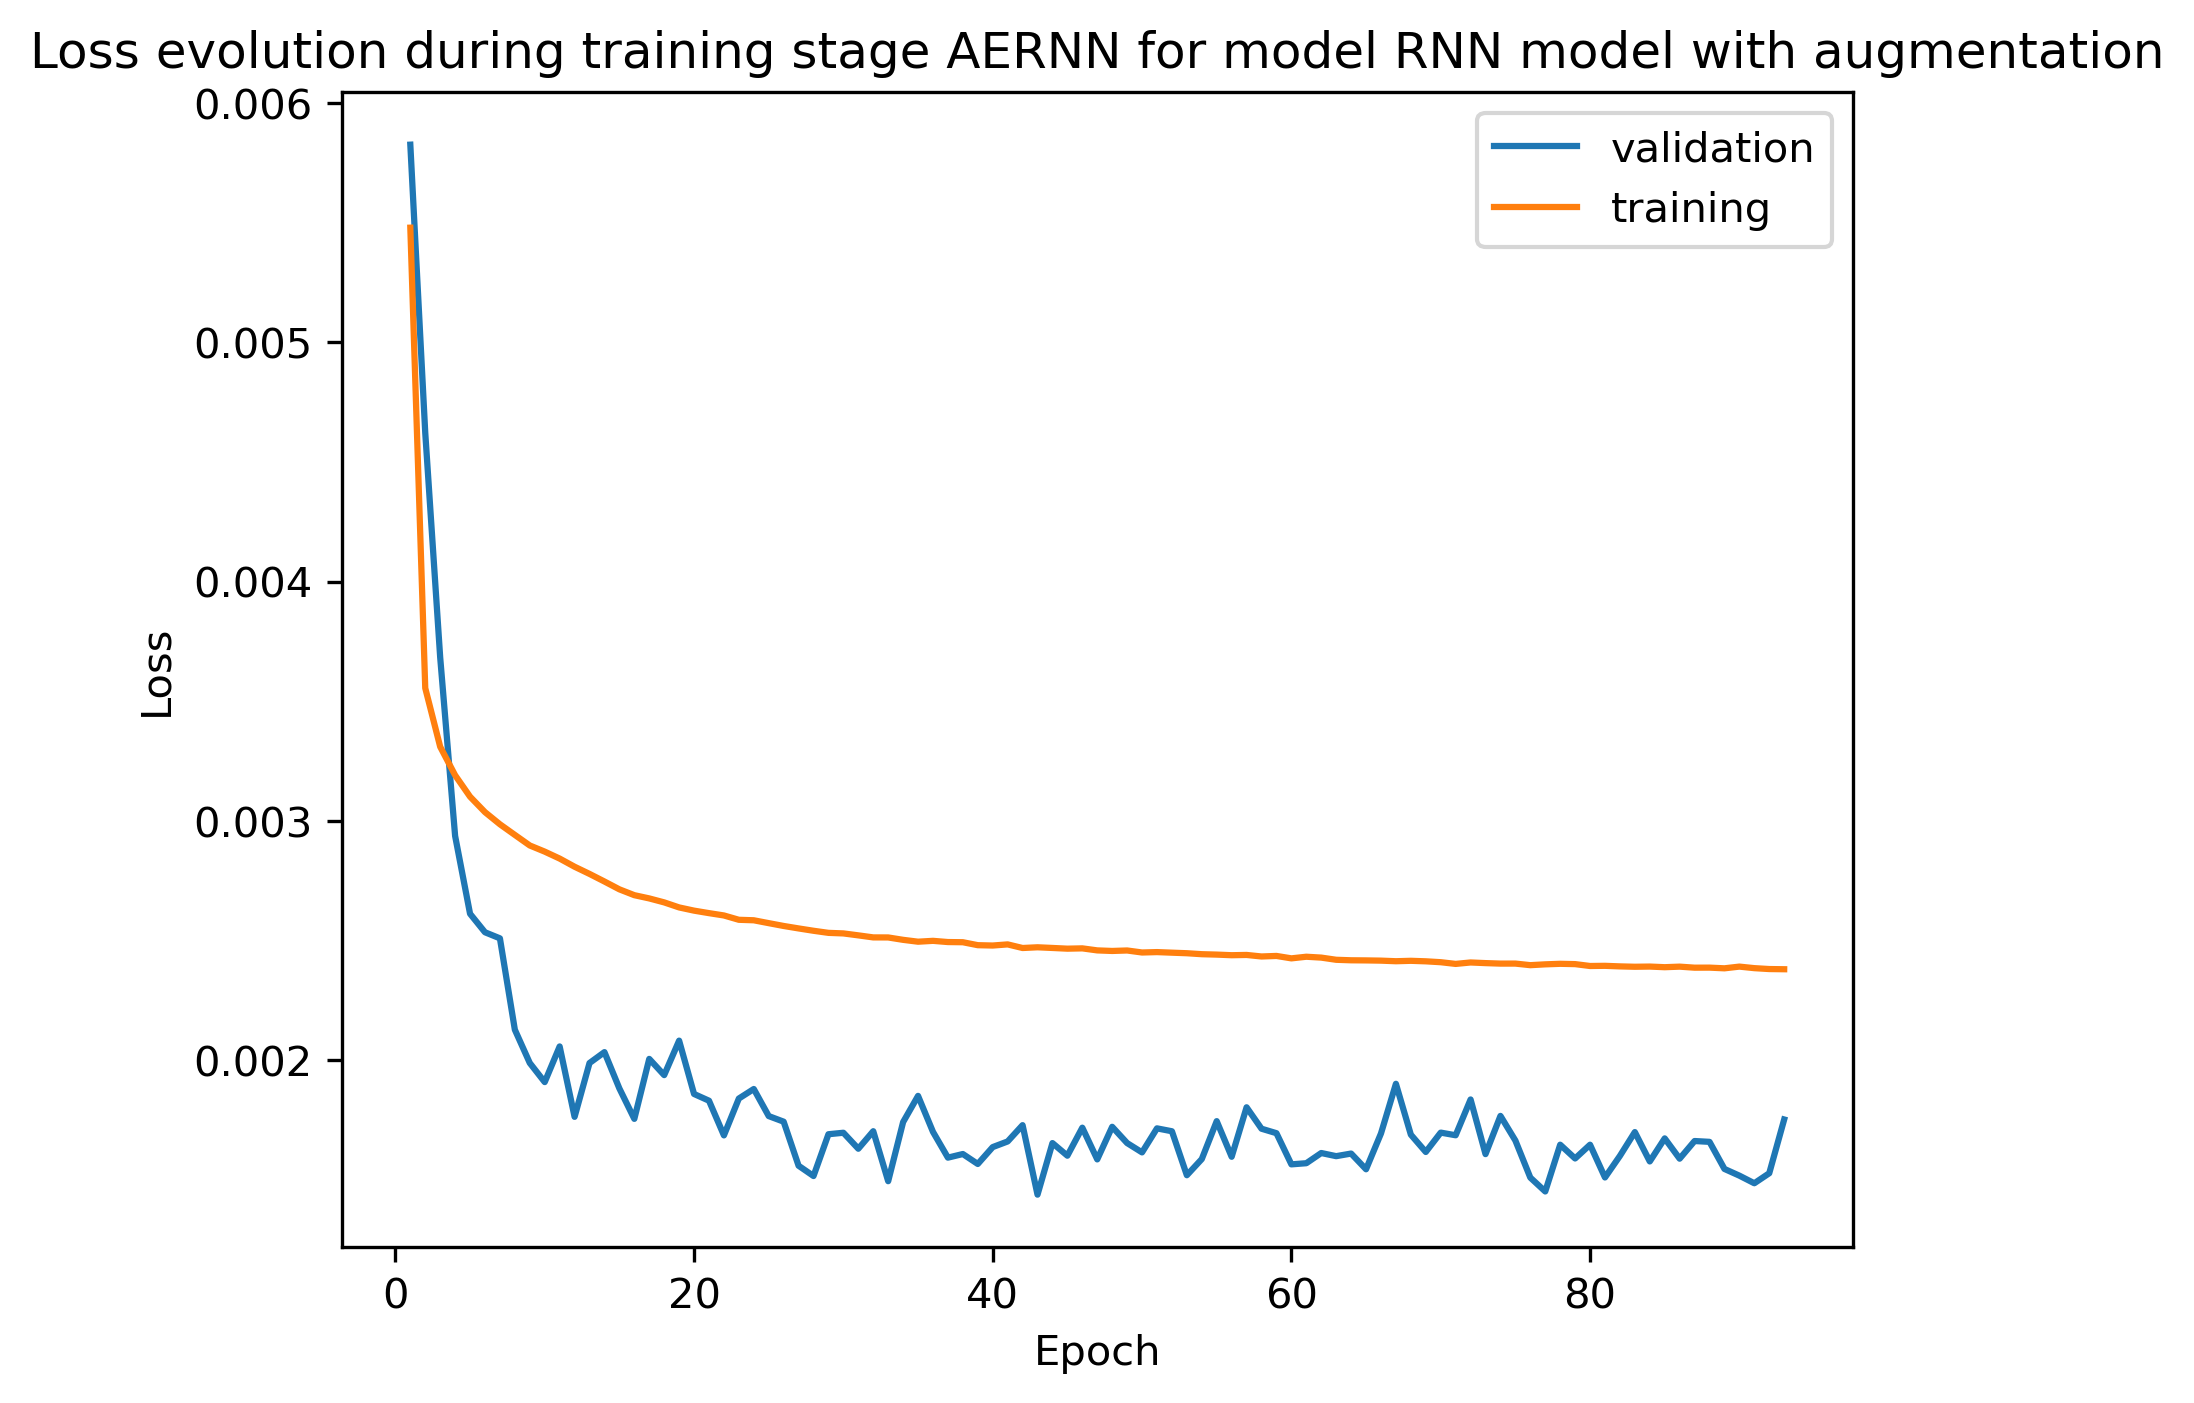

In [ ]:
metrics.show_curves([curves], [modelo_final], 'AERNN')
print()

In [22]:
import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)

only_classifier = False
early_stop = 15
augmentation = True
batch_size = 128

stage = 'rnn'
curves = ft.train_final_model(modelo_final,
                                              stage,
                                                train_dataset,
                                                validation_dataset,
                                                ae_loss,
                                                rnn_loss,
                                                max_epochs,
                                                max_time,
                                                batch_size,
                                                10e-6,
                                                random_sampler,
                                                only_classifier,
                                                augmentation,
                                                early_stop,
                                                use_gpu,
                                                num_cpu,
                                                0.015)

torch.save(modelo_final.state_dict(), f'models/{modelo_final.name}.pth')

Augmenting data...

Setup finishied. Starting training...
(0.02 min) Epoch 1/300 -- Iteration 38 - Batch 38/3851 - Train loss: 1.12005163  - Train acc: 0.2997 - Val loss: 0.00000000
(0.03 min) Epoch 1/300 -- Iteration 76 - Batch 76/3851 - Train loss: 1.10491521  - Train acc: 0.3315 - Val loss: 0.00000000
(0.04 min) Epoch 1/300 -- Iteration 114 - Batch 114/3851 - Train loss: 1.08652822  - Train acc: 0.3740 - Val loss: 0.00000000
(0.04 min) Epoch 1/300 -- Iteration 152 - Batch 152/3851 - Train loss: 1.06700349  - Train acc: 0.4144 - Val loss: 0.00000000
(0.05 min) Epoch 1/300 -- Iteration 190 - Batch 190/3851 - Train loss: 1.04535439  - Train acc: 0.4472 - Val loss: 0.00000000
(0.06 min) Epoch 1/300 -- Iteration 228 - Batch 228/3851 - Train loss: 1.01763238  - Train acc: 0.4810 - Val loss: 0.00000000
(0.07 min) Epoch 1/300 -- Iteration 266 - Batch 266/3851 - Train loss: 0.99021266  - Train acc: 0.5075 - Val loss: 0.00000000
(0.08 min) Epoch 1/300 -- Iteration 304 - Batch 304/3851 - Train

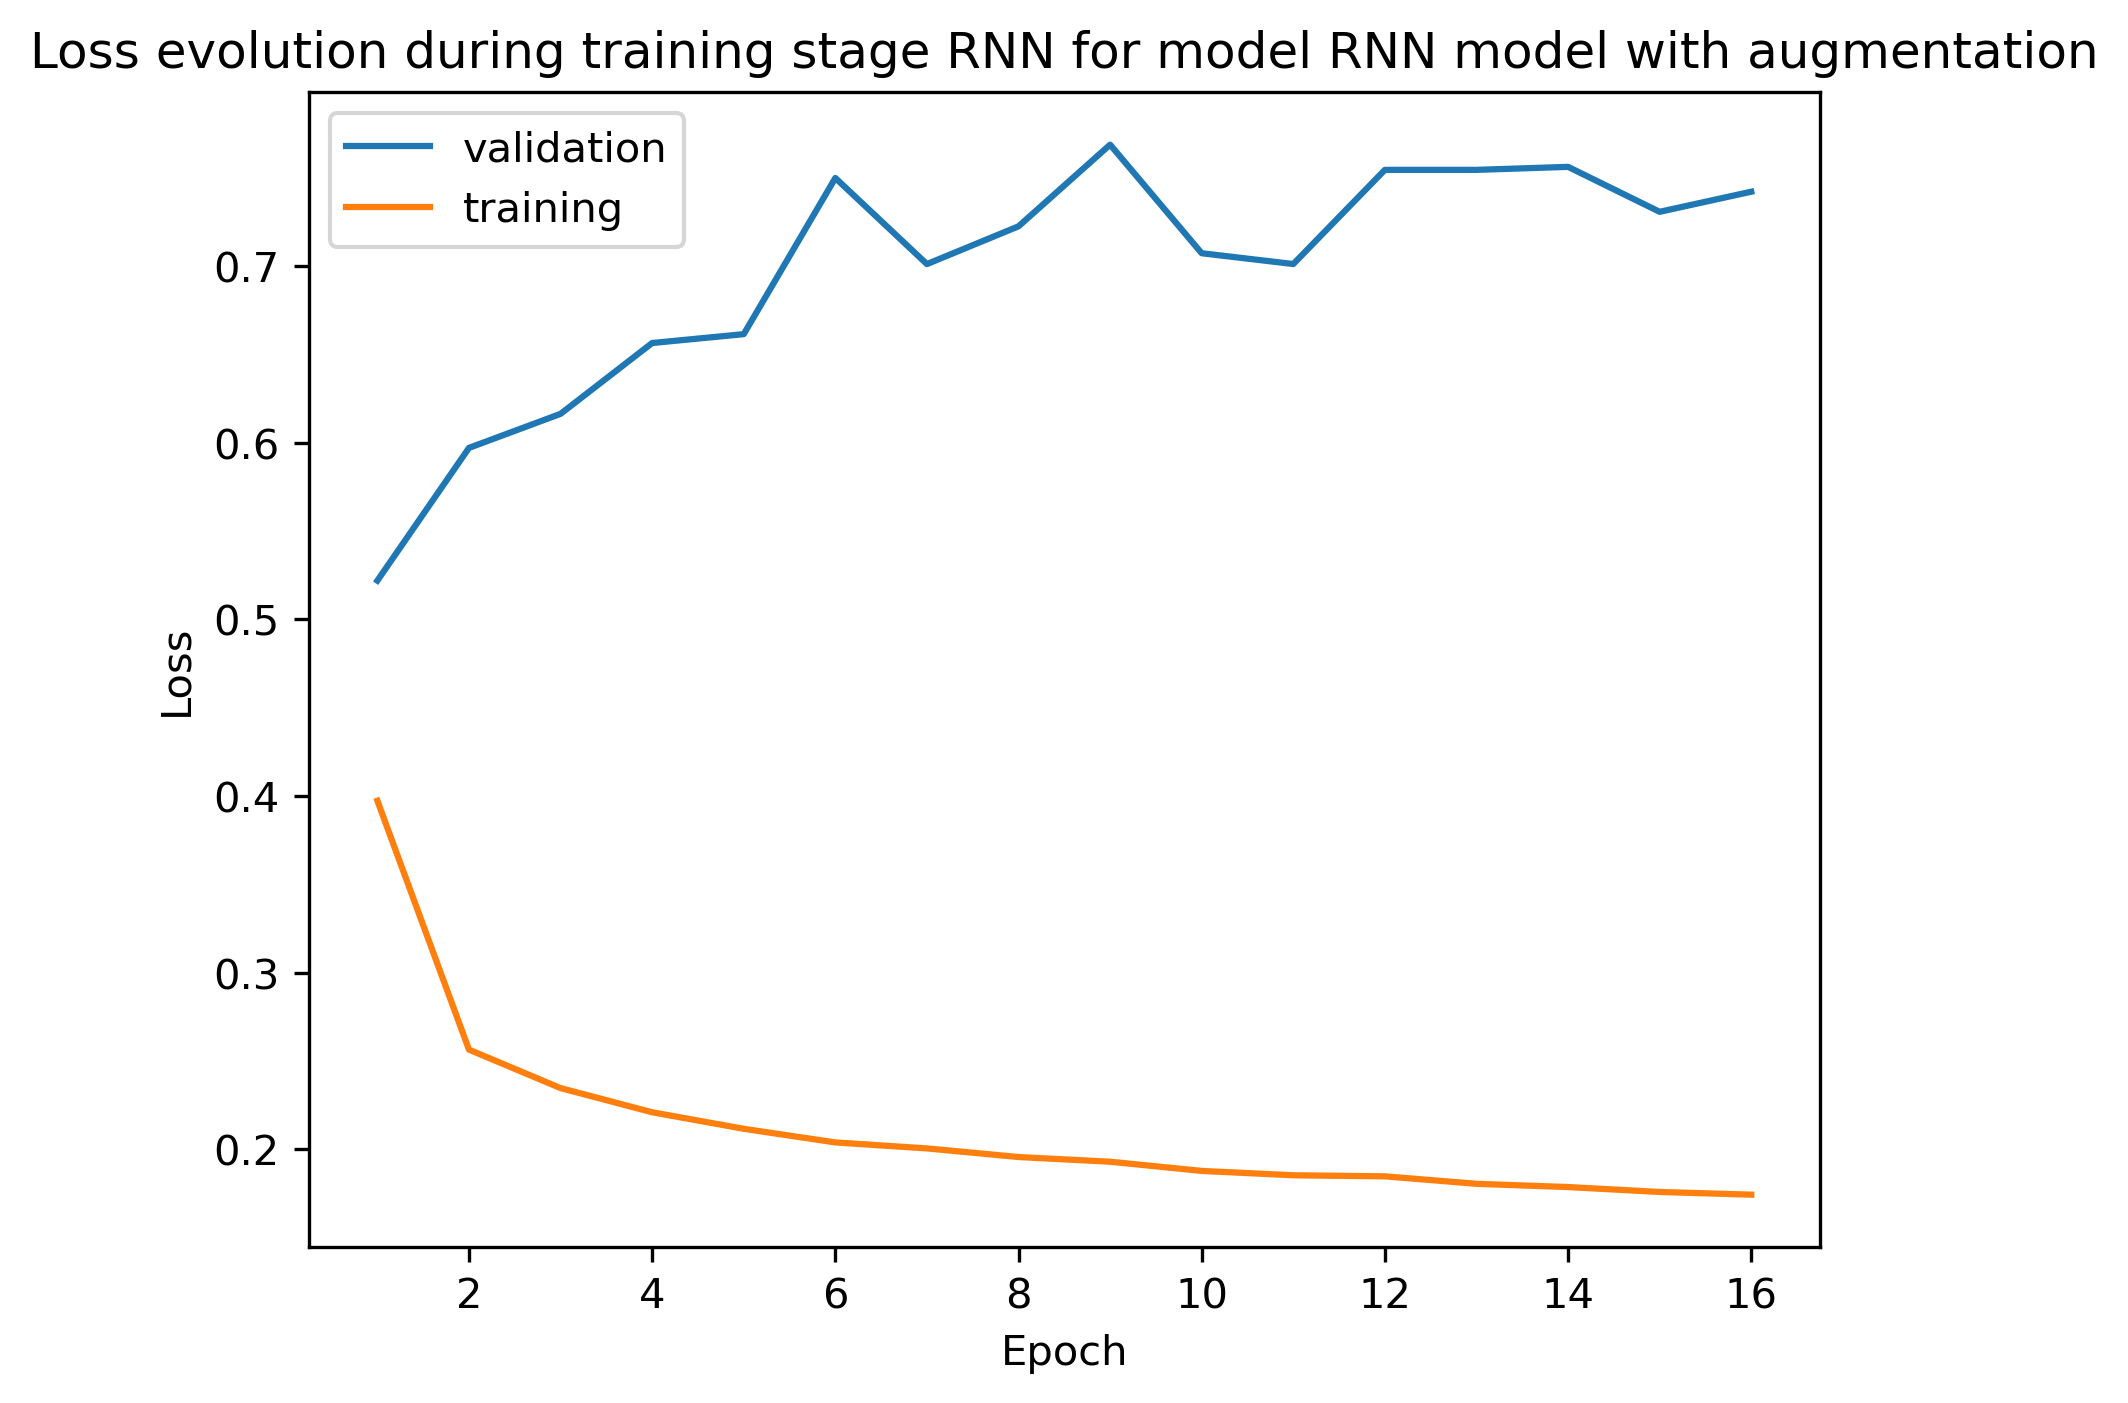

In [23]:
metrics.show_curves([curves], [modelo_final], 'RNN')
print()

# RESULTS

C:\Users\pmarc\AppData\Local\Temp\ipykernel_8956\625530811.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_final.load_state_dict(torch.load(f'models/1st_iteratio


Modelo RNN model
Precision: 0.767
Recall: 0.750
F1: 0.754


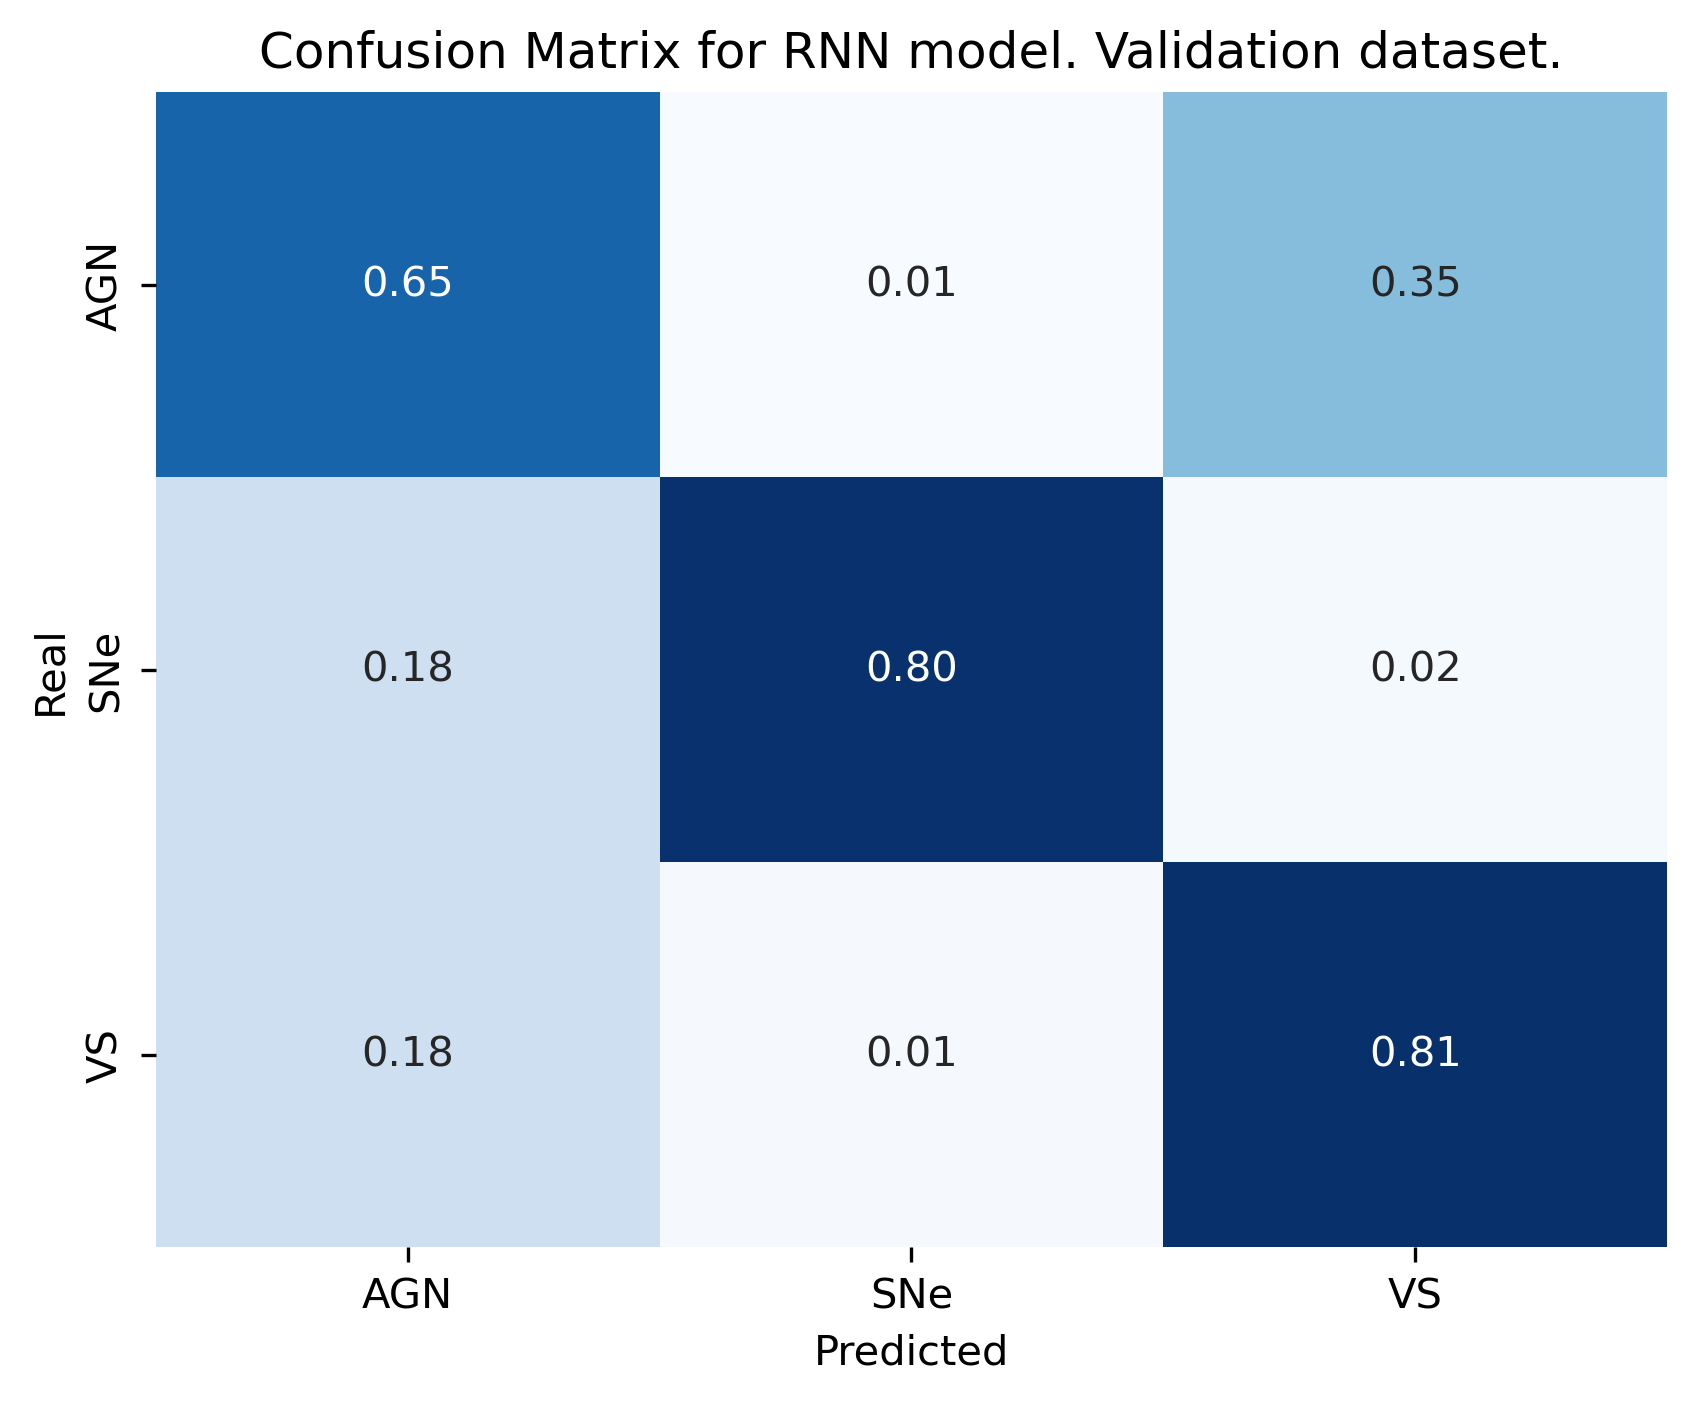

In [27]:
#validation
import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)
importlib.reload(src.utils.metrics)
importlib.reload(metrics)

modelo_final = fm.FinalModel(128, n_channels, 'RNN', 128, 1, dropout_prob,  n_classes, name='RNN model')
modelo_final.load_state_dict(torch.load(f'models/1st_iteration.pth'))

modelo_final.cpu()
modelo_final.eval()


prediction = modelo_final.rnn_classifier_test(validation_dataset.tensors[0])

cm = confusion_matrix(validation_dataset.tensors[1], prediction.argmax(dim=1), normalize='true')
print(f'\nModelo {modelo_final.name}')
metrics.plot_matrix([modelo_final], [cm], 'Validation')
precision, recall, f1 = metrics.performance_metrics(validation_dataset.tensors[1], prediction.argmax(dim=1))

print(f'Precision: {precision:.3f}'
      f'\nRecall: {recall:.3f}'
      f'\nF1: {f1:.3f}')


Modelo RNN model
Precision: 0.704
Recall: 0.698
F1: 0.693


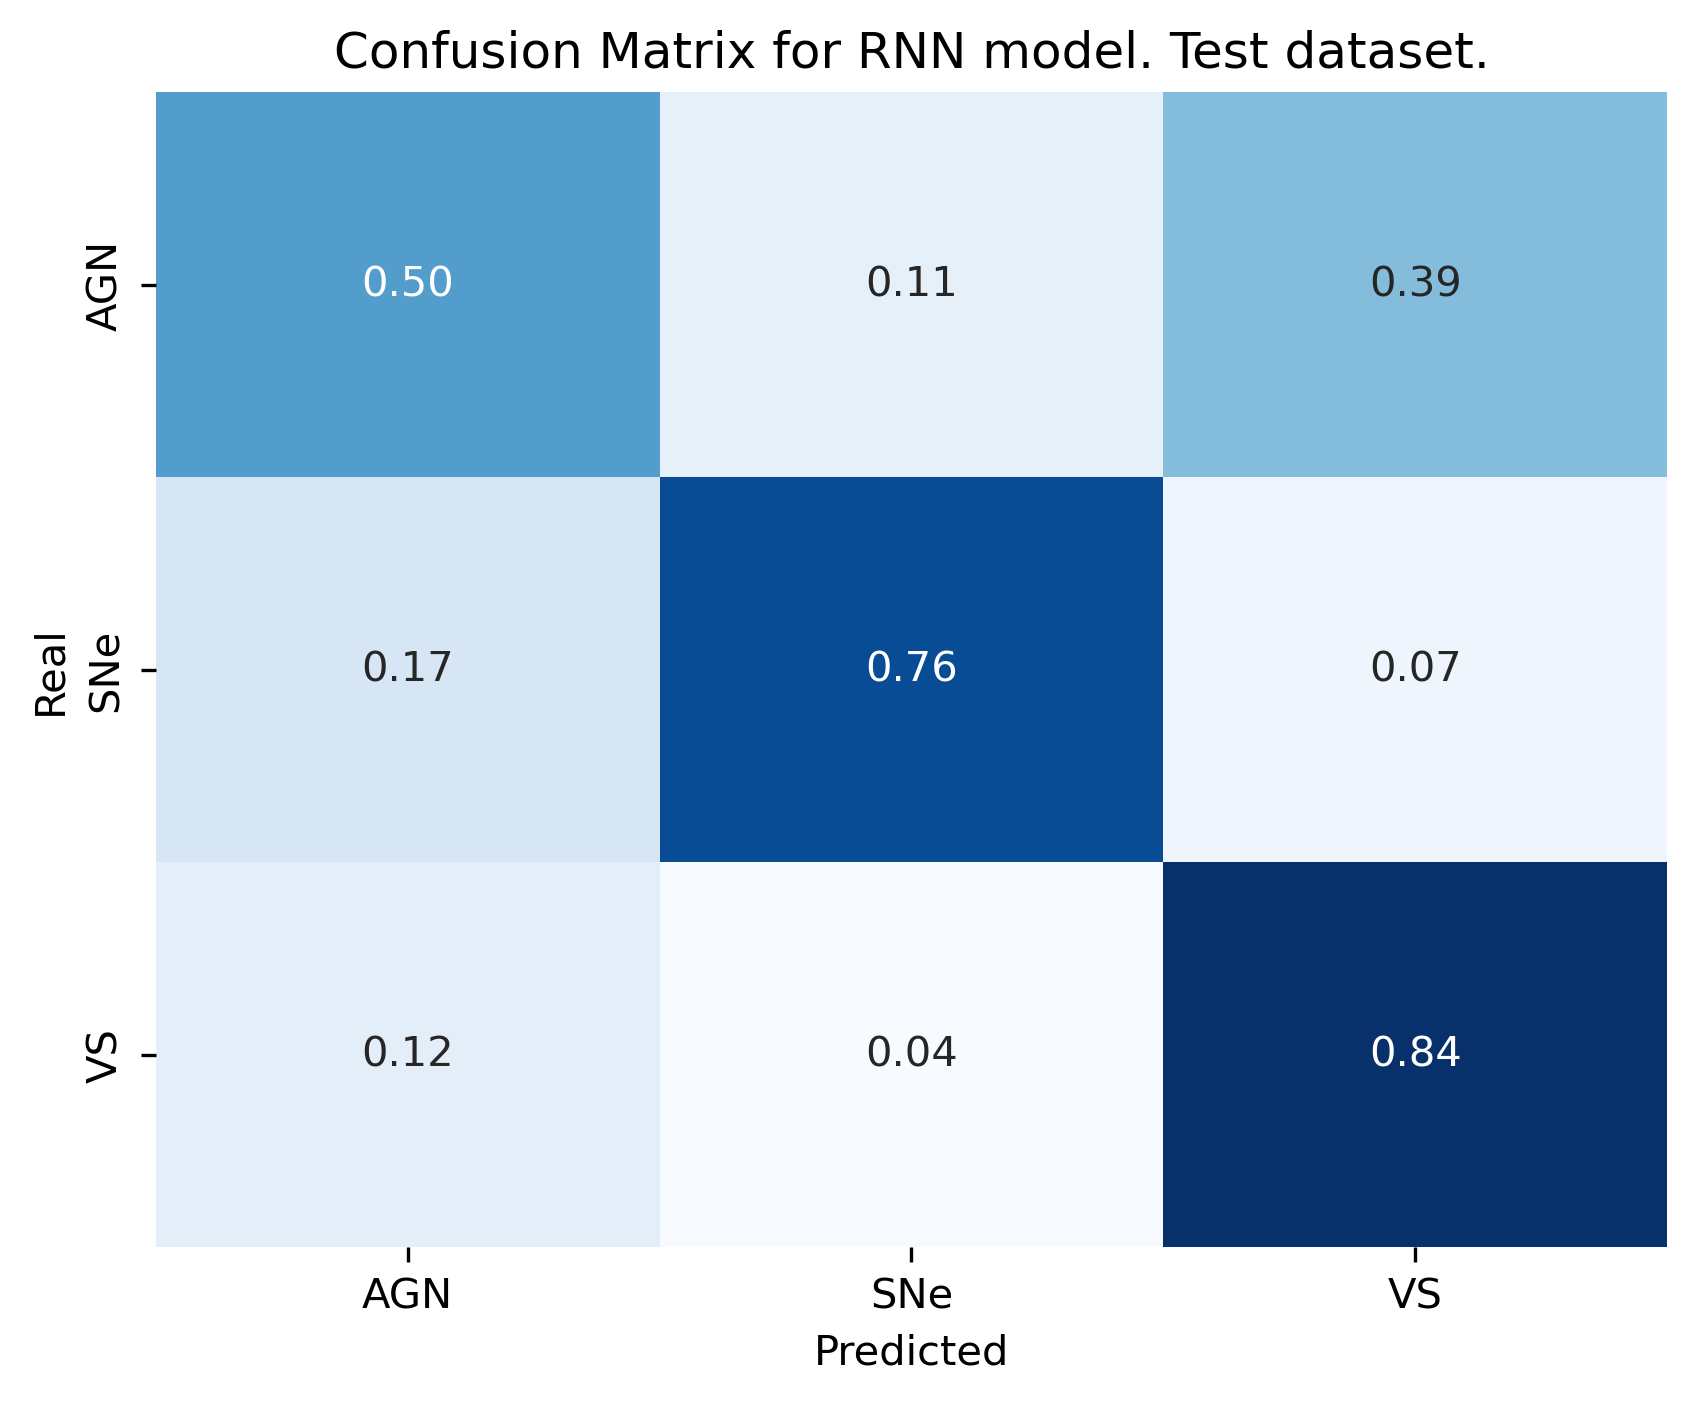

In [28]:
#test
modelo_final.eval()

prediction = modelo_final.rnn_classifier_test(test_dataset.tensors[0])
cm = confusion_matrix(test_dataset.tensors[1], prediction.argmax(dim=1), normalize='true')
print(f'\nModelo {modelo_final.name}')
metrics.plot_matrix([modelo_final], [cm], 'Test')
precision, recall, f1 = metrics.performance_metrics(test_dataset.tensors[1], prediction.argmax(dim=1))

print(f'Precision: {precision:.3f}'
      f'\nRecall: {recall:.3f}'
      f'\nF1: {f1:.3f}')


# Random Forest

In [29]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)

# modelo_final = fm.FinalModel(128, 3, 'LSTM', 128, 1, 0.35,  3, name='2nd_iteration')

# modelo_final.load_state_dict(torch.load(f'models/0_8_aernn.pth'))
modelo_final.eval()
modelo_final.cuda()

class_counts = torch.bincount(train_dataset.tensors[1].long())
class_weights = 1. / class_counts.float()
weights = class_weights[train_dataset.tensors[1].long()]

sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, num_workers=0, pin_memory=True)
features = []
labels = []

with torch.no_grad():
    for img, y_batch in train_loader:
        img = img.cuda()
        lat_spc = modelo_final.rnn_latent(img)
        features.append(lat_spc.cpu().numpy())
        labels.append(y_batch.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

In [13]:
print(features.shape)
print(labels.shape)

(123227, 21)
(123227,)


In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=15000, random_state=42, n_jobs = -1)
rf_classifier.fit(features, labels)

RandomForestClassifier(n_estimators=15000, n_jobs=-1, random_state=42)

In [34]:
# Extract features from the validation dataset
val_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)
val_features = []
val_labels = []

with torch.no_grad():
    for img, y_batch in val_loader:
        if True:
            img = img.cuda()
        lat_spc = modelo_final.rnn_latent(img)
        val_features.append(lat_spc.cpu().numpy())
        val_labels.append(y_batch.numpy())

val_features = np.concatenate(val_features, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Predict and evaluate
val_predictions = rf_classifier.predict(val_features)
accuracy = np.mean(val_predictions == val_labels)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.6250
